In [1]:
# import libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pytorch_lightning as pl

In [2]:
# check the environment
print("Current working directory: ", os.getcwd())
print("OS name: ", sys.platform)
print("Python executable: ", sys.executable)
print("Python version: ", sys.version)
print("PyTorch version: ", torch.__version__)
print("PyTorch Lightning version: ", pl.__version__)
print("CUDA version: ", torch.version.cuda)
print("cuDNN version: ", torch.backends.cudnn.version())
print("Number of GPUs: ", torch.cuda.device_count())
print("GPU model: ", torch.cuda.get_device_name(0))

Current working directory:  /gpfs02/work/akira.tokiwa/gpgpu/Github/SR3D/tests
OS name:  linux
Python executable:  /gpfs02/work/akira.tokiwa/gpgpu/anaconda3/envs/pylit/bin/python
Python version:  3.10.9 (main, Jan 11 2023, 15:21:40) [GCC 11.2.0]
PyTorch version:  2.0.1+cu117
PyTorch Lightning version:  1.9.3
CUDA version:  11.7
cuDNN version:  8500
Number of GPUs:  1
GPU model:  NVIDIA GeForce RTX 2080 Ti


In [3]:
# import modules
sys.path.append('../')
from scripts.dataloader.data import get_loaders_from_params, get_data_from_params, get_normalized_from_params, get_loaders, Transforms
from scripts.models.Unet_base import Unet
from scripts.diffusion.ddpm import DDPM
from scripts.diffusion.scheduler import TimestepSampler
from scripts.utils.run_utils import setup_trainer, get_parser
from scripts.params import set_params

In [4]:
pl.seed_everything(1234)

[rank: 0] Global seed set to 1234


1234

In [5]:
params = set_params(n_maps=10,use_attn=True,batch_size=4)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
### get training data
lr, hr = get_data_from_params(params)
lr, hr = lr.unsqueeze(1), hr.unsqueeze(1)
log2linear_transform = Transforms("log2linear", None, None)
lr, hr = log2linear_transform.inverse_transform(lr), log2linear_transform.inverse_transform(hr)
data_input, data_cond, transforms_input, transforms_cond = get_normalized_from_params(lr, hr, params)
train_loader, val_loader = get_loaders(data_input, data_cond, params["train"]['train_rate'], params["train"]['batch_size'])
print("train:validation = {}:{}, batch_size: {}".format(len(train_loader), len(val_loader), params["train"]['batch_size']))


LR data loaded from /gpfs02/work/tanimura/ana/UNet/data/dens_magneticum_snap25_Box128_grid32_CIC_noRSD/.  Number of maps: 10
HR data loaded from /gpfs02/work/tanimura/ana/UNet/data/dens_magneticum_snap25_Box128_grid64_CIC_noRSD/.  Number of maps: 10
LR data normalized to [0.7814010381698608,0.9868751168251038] by sigmoid transform.
HR data normalized to [0.5889384150505066,0.9841253757476807] by sigmoid transform.
train:validation = 2:1, batch_size: 4


In [14]:
#get sampler type
sampler = TimestepSampler(
timesteps=int(params['diffusion']['timesteps']), 
sampler_type=params['diffusion']['sampler_type'])
print("sampler type: {}, timesteps: {}".format(params['diffusion']['sampler_type'], params['diffusion']['timesteps']))

#get model
model = DDPM(Unet, params, sampler = sampler)


Sampler type uniform
sampler type: uniform, timesteps: 2000
We are using Adam with lr = 0.0001, gamma = 0.9999
The schedule is linear with beta_start = 1e-06, beta_end = 0.01


# Generate map

In [15]:
ckpt_dir = params["train"]["save_dir"]+params["train"]["log_name"]+"/version_8/checkpoints/last.ckpt"
model.load_state_dict(torch.load(ckpt_dir)["state_dict"])
model = model.to(device)

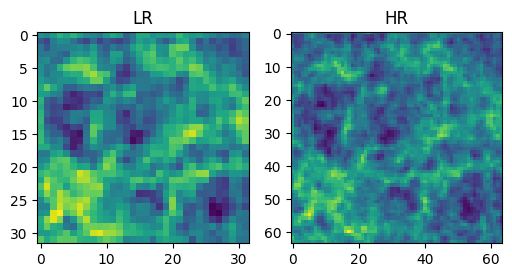

In [17]:
# project the data to 2D
lr_proj = data_cond[0].cpu().numpy()
lr_proj = lr_proj.squeeze(0)
lr_proj = np.sum(lr_proj, axis=0)

hr_proj = data_input[0].cpu().numpy()
hr_proj = hr_proj.squeeze(0)
hr_proj = np.sum(hr_proj, axis=0)

fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].imshow(lr_proj)
ax[0].set_title("LR")
ax[1].imshow(hr_proj)
ax[1].set_title("HR")
plt.show()

In [38]:
tmp_cond = data_cond[:1].to(device)
timesteps = int(params["diffusion"]["timesteps"] * 3/4)
save_step = 100

model.eval()
imgs = []
img = torch.randn_like(data_input[:1]).to(device)
for j in reversed(range(0, timesteps)):
    t = torch.full((tmp_cond.shape[0],), j, device=device, dtype=torch.long)
    img = model.diffusion.p_sample(model.model, img, t, j, condition=tmp_cond)
    if (j % save_step == 0):
        print("Current step: {}".format(j))
        imgs.append(img.detach().cpu().numpy())

Current step: 1400
Current step: 1300
Current step: 1200
Current step: 1100
Current step: 1000
Current step: 900
Current step: 800
Current step: 700
Current step: 600
Current step: 500
Current step: 400
Current step: 300
Current step: 200
Current step: 100
Current step: 0


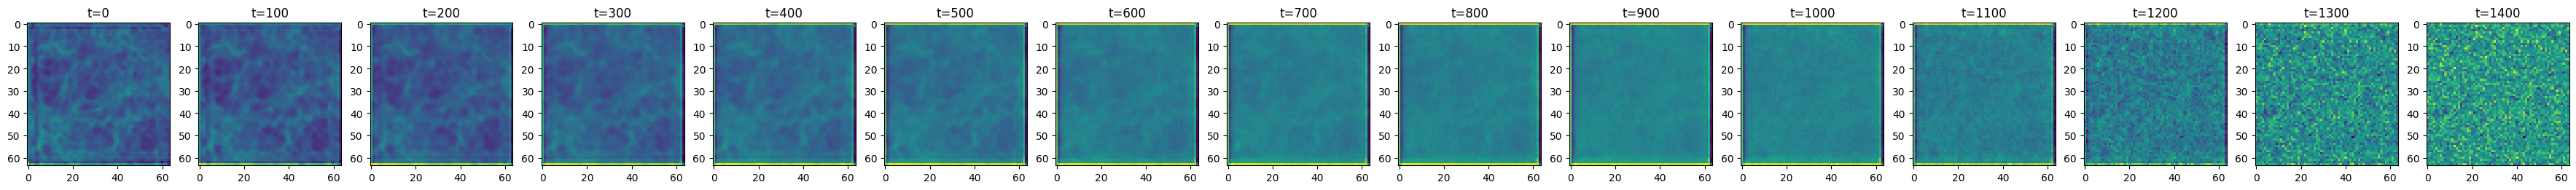

In [39]:
map_dir = params["train"]["save_dir"] + "../../img/generated"
os.makedirs(map_dir, exist_ok=True)
num_imgs = timesteps // save_step
fig, ax = plt.subplots(1, num_imgs, figsize=(num_imgs*3, 3))
for i in range(num_imgs):
    ax[i].imshow(imgs[-(i+1)].squeeze(0).squeeze(0).sum(axis=0))
    ax[i].set_title("t={}".format(i*save_step))
plt.show()

In [40]:
display_num = 5
random_idx = np.random.randint(0, data_input.shape[-1], display_num)

In [45]:
cond_upsample = model.model.cond_upsample(tmp_cond[:1])

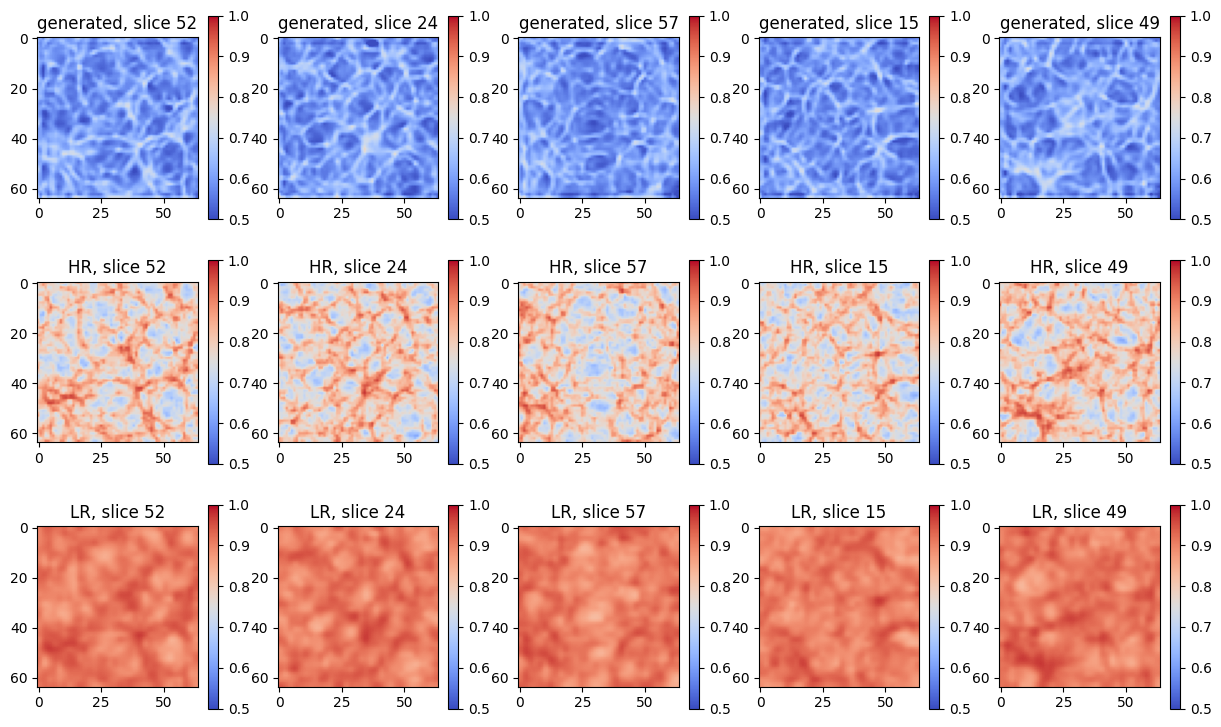

In [48]:
fig, ax = plt.subplots(3,display_num, figsize=(display_num * 3, 9))
for i in range(display_num):
    # plot with colorbar
    im = ax[0,i].imshow(imgs[-1][0, 0, random_idx[i], :, :], vmin=0.5, vmax=1,  cmap='coolwarm')
    ax[0,i].set_title("generated, slice {}".format(random_idx[i]))
    fig.colorbar(im, ax=ax[0,i])
    
    im = ax[1,i].imshow(data_input[:1].squeeze(0).squeeze(0).cpu().numpy()[random_idx[i]], vmin=0.5, vmax=1, cmap='coolwarm')
    ax[1,i].set_title("HR, slice {}".format(random_idx[i]))
    fig.colorbar(im, ax=ax[1,i])

    im = ax[2,i].imshow(cond_upsample.squeeze(0).squeeze(0).cpu().numpy()[random_idx[i]], vmin=0.5, vmax=1, cmap='coolwarm')
    ax[2,i].set_title("LR, slice {}".format(random_idx[i]))
    fig.colorbar(im, ax=ax[2,i])
plt.show()